In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Price.csv


# This is one of our selected model which are being used in our webapp backend from all the models we train

## LSTM used for predicting daily prices

## Accuracy : 98%
## RMS error : 2.35

In [14]:
from sklearn.metrics import r2_score,mean_squared_error
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras.layers import Dropout
plt.style.use('fivethirtyeight')


In [15]:
data = pd.read_csv("../input/Price.csv")
data.head(5)

,Date,Traded Contract(Lots),Quantity (000's),Total Value (Lacs),Instrument Type
0,03-Oct-11,384,9.60,1773.14,FUTCOM
1,04-Oct-11,603,15.08,2782.83,FUTCOM
2,05-Oct-11,403,10.08,1850.26,FUTCOM
3,06-Oct-11,0,0.00,0.00,FUTCOM
4,07-Oct-11,192,4.80,884.20,FUTCOM


In [16]:
data = data[data['Total Value (Lacs)']!=0]
data['price'] = data['Total Value (Lacs)']/data["Quantity (000's)"]

df = pd.DataFrame(data['price'])
dataset = df.values#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.75) 

#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]#Split the data into x_train and y_train data sets



Reached here
Epoch 1/15
429/429 [==============================] - 25s 58ms/step - loss: 0.0076
Epoch 2/15
429/429 [==============================] - 25s 57ms/step - loss: 0.0024
Epoch 3/15
429/429 [==============================] - 25s 57ms/step - loss: 0.0018
Epoch 4/15
429/429 [==============================] - 25s 58ms/step - loss: 0.0016
Epoch 5/15
429/429 [==============================] - 25s 58ms/step - loss: 0.0016
Epoch 6/15
429/429 [==============================] - 25s 59ms/step - loss: 0.0014
Epoch 7/15
429/429 [==============================] - 26s 61ms/step - loss: 0.0013
Epoch 8/15
429/429 [==============================] - 25s 59ms/step - loss: 0.0013
Epoch 9/15
429/429 [==============================] - 25s 59ms/step - loss: 0.0012
Epoch 10/15
429/429 [==============================] - 26s 60ms/step - loss: 0.0013
Epoch 11/15
429/429 [==============================] - 25s 58ms/step - loss: 0.0012
Epoch 12/15
429/429 [==============================] - 26s 60ms/step - l

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


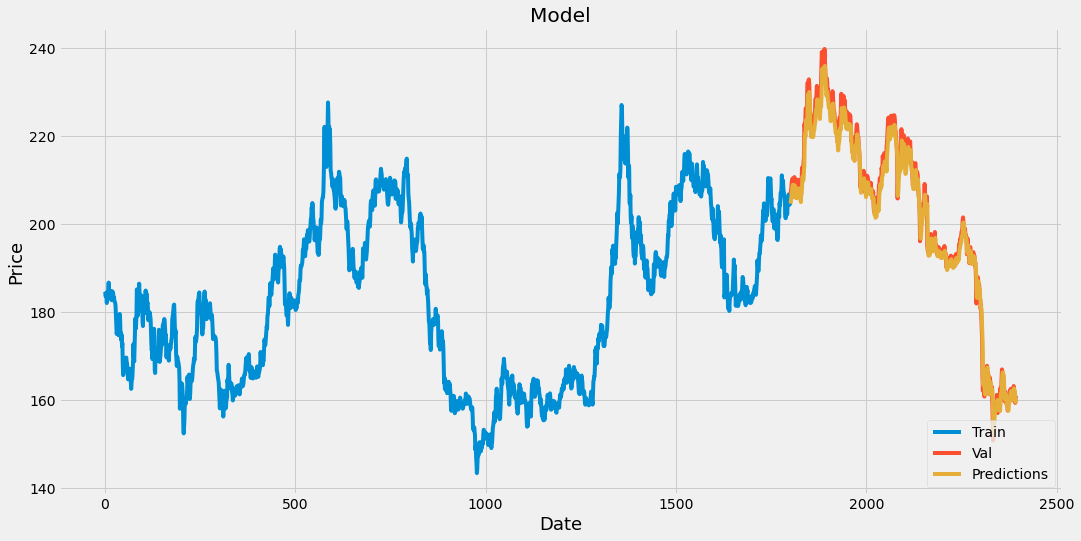

2.3538235431861017


In [17]:
time = 60
neurons = 40
optimizer='rmsprop'
batch=4
epochs=15

x_train=[]
y_train = []
for i in range(time,len(train_data)):
    x_train.append(train_data[i-time:i,0])
    y_train.append(train_data[i,0])
#Convert x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

#Build the LSTM network model
model = Sequential()
model.add(LSTM(units=neurons, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=neurons, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')
print("Reached here")

#Train the model
model.fit(x_train, y_train, batch_size=batch, epochs=epochs)

#Test data set
test_data = scaled_data[training_data_len - time: , : ]#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(time,len(test_data)):
    x_test.append(test_data[i-time:i,0])

#Convert x_test to a numpy array 
x_test = np.array(x_test)

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

#Plot/Create the data for the graph
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(train)
plt.plot(valid)
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.savefig('img2-'+str(time)+str(neurons)+str(optimizer)+str(batch)+str(epochs)+'.png')
plt.show()

#save the model
model_json = model.to_json()
with open("model2-"+str(time)+str(neurons)+str(optimizer)+str(batch)+str(epochs)+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model2-"+str(time)+str(neurons)+str(optimizer)+str(batch)+str(epochs)+".h5")


#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
print(rmse)

In [18]:
print("Accuracy Score -> ",r2_score(y_test,predictions))

Accuracy Score ->  0.9881182097921278


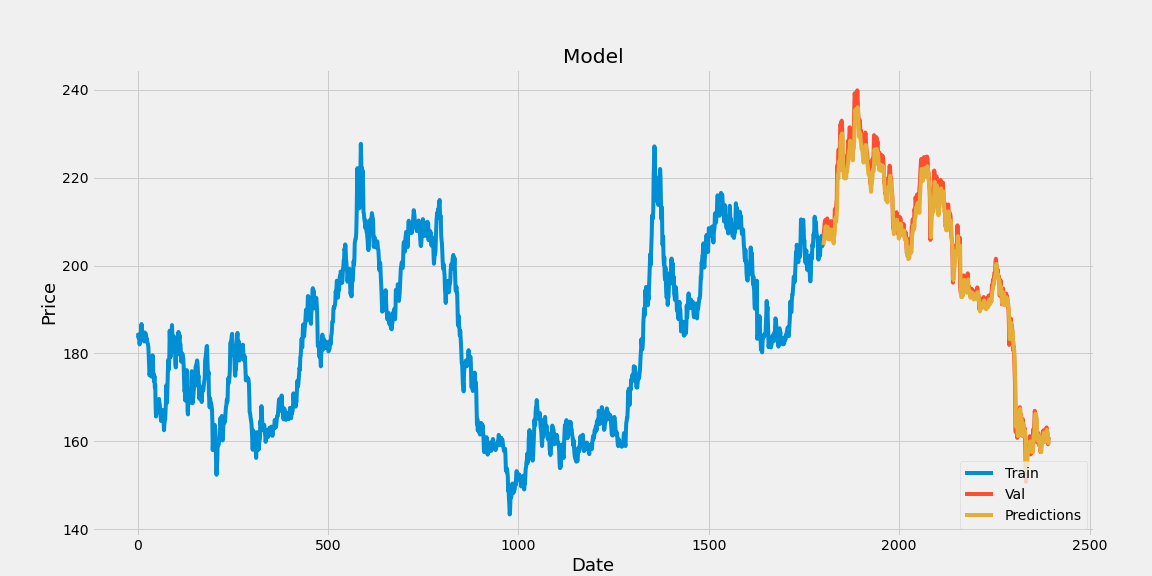